# Stage 1

## Setup

In [1]:
# PSNR/SSIM Goalposts
# Gaussian Blur: 20.5/0.65 - DONE
# Motion Blur: 21.5/0.70 - NEEDS MORE WORK
# Salt and Pepper noise: 26.5/0.90 - DONE
# Gaussian noise: 19.5/0.60 - DONE
# Speckle noise: 20.0/0.65 - DONE

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from tqdm.notebook import tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted
from glob import glob
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage import filters
from skimage.restoration import wiener
from skimage.restoration import denoise_nl_means
from skimage.restoration import unsupervised_wiener
from skimage.restoration import richardson_lucy
import cv2
from scipy.fftpack import fft2, ifft2

## Salt and Pepper Noise (26.77/0.92)

In [ ]:
noisy_files = natsorted(glob("/content/drive/MyDrive/188/stage1_data/sp_noise/*"))
clean_files = natsorted(glob("/content/drive/MyDrive/188/stage1_data/input_imgs/*"))
print(len(noisy_files))
print(len(clean_files))

11
11


In [ ]:
# Apply Median filter with varying kernel_sizes for maximum PSNR and SSIM

kernel_sizes = [1, 2, 3, 4, 5, 7, 11, 15]

psnr_sum = 0
ssim_sum = 0

imgs = []
noisy_imgs = []
filtered_imgs = []

for noisy_file, clean_file in tqdm(zip(noisy_files, clean_files)):
  img = np.array(Image.open(clean_file)) / 255.0
  noisy_img = np.array(Image.open(noisy_file)) / 255.0

  imgs.append(img)
  noisy_imgs.append(noisy_img)

  red_channel = noisy_img[:,:,0]
  green_channel = noisy_img[:,:,1]
  blue_channel = noisy_img[:,:,2]

  pref_kernel_size = -1
  max_psnr = -1
  max_ssim = -1

  for kernel_size in kernel_sizes:
    filtered_red = filters.median(red_channel, selem=np.ones((kernel_size, kernel_size)))
    filtered_green = filters.median(green_channel, selem=np.ones((kernel_size, kernel_size)))
    filtered_blue = filters.median(blue_channel, selem=np.ones((kernel_size, kernel_size)))

    filtered_img = np.stack((filtered_red, filtered_green, filtered_blue), axis=-1)

    curr_psnr = psnr(img, filtered_img)
    curr_ssim = ssim(img, filtered_img, multichannel=True)

    if (curr_psnr > max_psnr and curr_ssim > max_ssim):
      max_ssim = curr_ssim
      max_psnr = curr_psnr
      pref_kernel_size = kernel_size

  filtered_red = filters.median(red_channel, selem=np.ones((pref_kernel_size, pref_kernel_size)))
  filtered_green = filters.median(green_channel, selem=np.ones((pref_kernel_size, pref_kernel_size)))
  filtered_blue = filters.median(blue_channel, selem=np.ones((pref_kernel_size, pref_kernel_size)))

  filtered_img = np.stack((filtered_red, filtered_green, filtered_blue), axis=-1)
  filtered_imgs.append(filtered_img)

  psnr_sum += max_psnr
  ssim_sum += max_ssim

print(psnr_sum/11.0)
print(ssim_sum/11.0)

0it [00:00, ?it/s]

26.765740881545092
0.9232724604869713


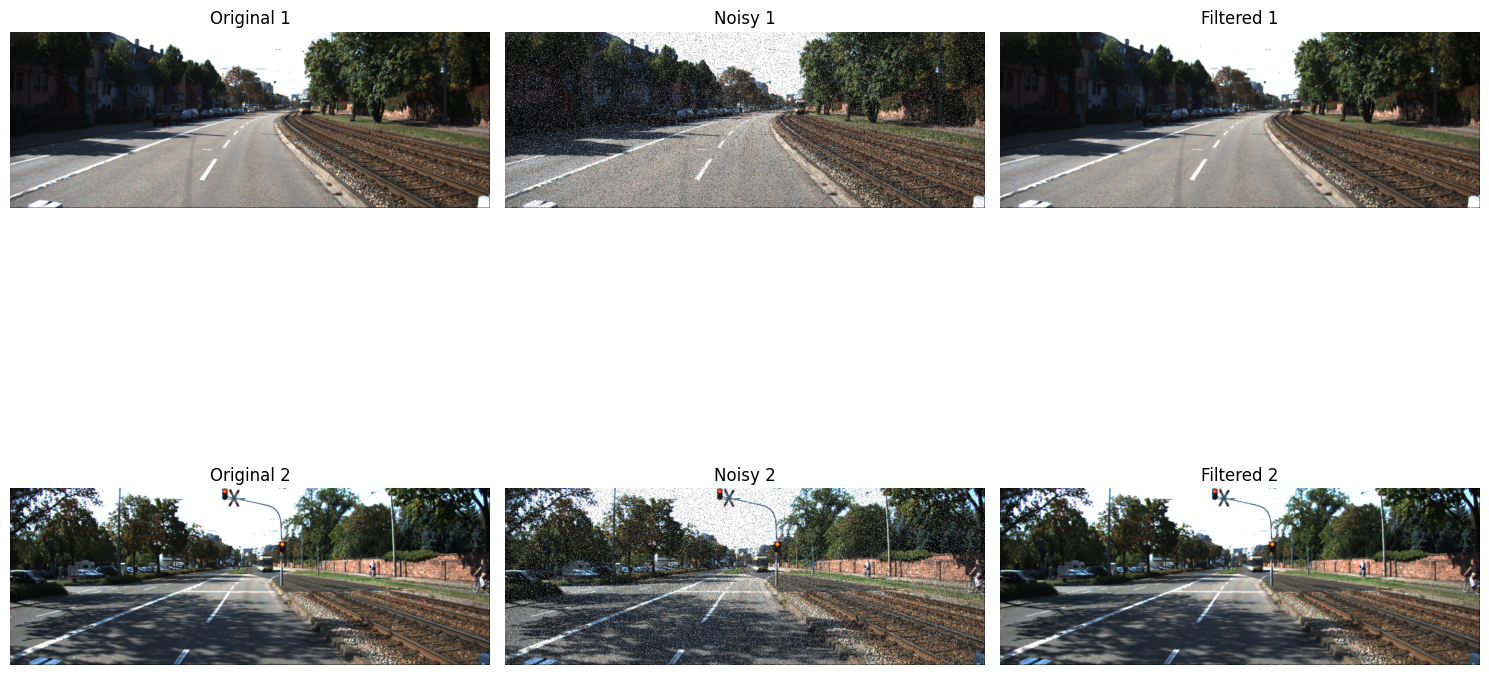

In [ ]:
fig = plt.figure(figsize=(15, 12))
rows = 2
columns = 3

fig.add_subplot(rows, columns, 1)
plt.imshow(imgs[0])
plt.axis('off')
plt.title("Original 1")

fig.add_subplot(rows, columns, 2)
plt.imshow(noisy_imgs[0])
plt.axis('off')
plt.title("Noisy 1")

fig.add_subplot(rows, columns, 3)
plt.imshow(filtered_imgs[0])
plt.axis('off')
plt.title("Filtered 1")

fig.add_subplot(rows, columns, 4)
plt.imshow(imgs[-1])
plt.axis('off')
plt.title("Original 2")

fig.add_subplot(rows, columns, 5)
plt.imshow(noisy_imgs[-1])
plt.axis('off')
plt.title("Noisy 2")

fig.add_subplot(rows, columns, 6)
plt.imshow(filtered_imgs[-1])
plt.axis('off')
plt.title("Filtered 2")

fig.tight_layout()

## Gaussian noise (19.93/0.64)

In [ ]:
noisy_files = natsorted(glob('/content/drive/MyDrive/188/stage1_data/gaussian_noise/*'))
clean_files = natsorted(glob('/content/drive/MyDrive/188/stage1_data/input_imgs/*'))
print(len(noisy_files))
print(len(clean_files))

11
11


In [ ]:
# Apply Gaussian blur to smooth out the Gaussian noise in the images. Try different kernel sizes.

kernel_sizes = [3, 5, 7, 9, 11, 15]

psnr_sum = 0
ssim_sum = 0

imgs = []
noisy_imgs = []
denoised_imgs = []

for noisy_file, clean_file in tqdm(zip(noisy_files, clean_files)):
  img = np.array(Image.open(clean_file)) / 255.0
  noisy_img = np.array(Image.open(noisy_file)) / 255.0

  imgs.append(img)
  noisy_imgs.append(noisy_img)

  red_channel = noisy_img[:,:,0]
  green_channel = noisy_img[:,:,1]
  blue_channel = noisy_img[:,:,2]

  pref_kernel_size = -1
  max_psnr = -1
  max_ssim = -1

  for kernel_size in kernel_sizes:
    denoised_red = cv2.GaussianBlur(red_channel, (kernel_size, kernel_size), 0)
    denoised_blue = cv2.GaussianBlur(blue_channel, (kernel_size, kernel_size), 0)
    denoised_green = cv2.GaussianBlur(green_channel, (kernel_size, kernel_size), 0)

    denoised_img = np.stack((denoised_red, denoised_green, denoised_blue), axis=-1)

    curr_psnr = psnr(img, denoised_img)
    curr_ssim = ssim(img, denoised_img, multichannel=True)

    if (curr_psnr > max_psnr and curr_ssim > max_ssim):
      max_ssim = curr_ssim
      max_psnr = curr_psnr
      pref_kernel_size = kernel_size

  denoised_red = cv2.GaussianBlur(red_channel, (pref_kernel_size, pref_kernel_size), 0)
  denoised_blue = cv2.GaussianBlur(blue_channel, (pref_kernel_size, pref_kernel_size), 0)
  denoised_green = cv2.GaussianBlur(green_channel, (pref_kernel_size, pref_kernel_size), 0)

  denoised_img = np.stack((denoised_red, denoised_green, denoised_blue), axis=-1)
  denoised_imgs.append(denoised_img)

  psnr_sum += max_psnr
  ssim_sum += max_ssim

print(psnr_sum/11.0)
print(ssim_sum/11.0)

0it [00:00, ?it/s]

19.932947901787653
0.6395950438823099


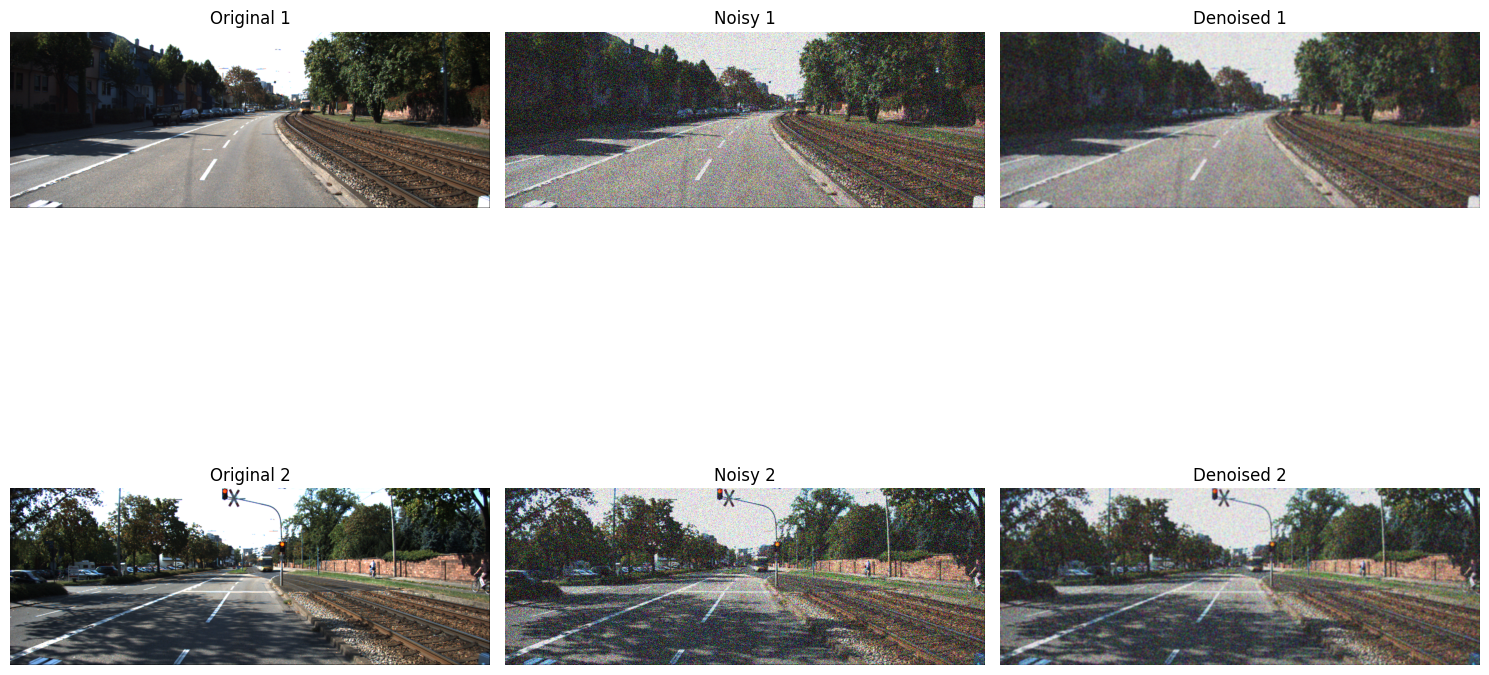

In [ ]:
fig = plt.figure(figsize=(15, 12))
rows = 2
columns = 3

fig.add_subplot(rows, columns, 1)
plt.imshow(imgs[0])
plt.axis('off')
plt.title("Original 1")

fig.add_subplot(rows, columns, 2)
plt.imshow(noisy_imgs[0])
plt.axis('off')
plt.title("Noisy 1")

fig.add_subplot(rows, columns, 3)
plt.imshow(denoised_imgs[0])
plt.axis('off')
plt.title("Denoised 1")

fig.add_subplot(rows, columns, 4)
plt.imshow(imgs[-1])
plt.axis('off')
plt.title("Original 2")

fig.add_subplot(rows, columns, 5)
plt.imshow(noisy_imgs[-1])
plt.axis('off')
plt.title("Noisy 2")

fig.add_subplot(rows, columns, 6)
plt.imshow(denoised_imgs[-1])
plt.axis('off')
plt.title("Denoised 2")

fig.tight_layout()

## Speckle noise (22.84/0.76)

In [ ]:
noisy_files = natsorted(glob('/content/drive/MyDrive/188/stage1_data/speckle_noise/*'))
clean_files = natsorted(glob('/content/drive/MyDrive/188/stage1_data/input_imgs/*'))
print(len(noisy_files))
print(len(clean_files))

11
11


In [ ]:
# Non-local means filter is supposed to work well with speckle noise, as it looks for pixels that are similar value across the image to smooth it out.
# https://www.semanticscholar.org/paper/Performance-Evaluation-of-Various-Filters-for-Noise-Wilson/87ce984f73da37f06a8807a72cb555d20c735c63/figure/0
# Try different patch sizes and distances for best results.

patch_sizes = [3, 5, 7, 11, 15]
patch_distances = [3, 5, 11, 15, 20]
psnr_sum = 0
ssim_sum = 0

imgs = []
noisy_imgs = []
denoised_imgs = []

for noisy_file, clean_file in tqdm(zip(noisy_files, clean_files)):
    img = np.array(Image.open(clean_file)) / 255.0
    noisy_img = np.array(Image.open(noisy_file)) / 255.0

    imgs.append(img)
    noisy_imgs.append(noisy_img)

    red_channel = noisy_img[:,:,0]
    green_channel = noisy_img[:,:,1]
    blue_channel = noisy_img[:,:,2]

    pref_patch_size = -1
    pref_patch_distance = -1
    max_psnr = -1
    max_ssim = -1

    for patch_size in patch_sizes:
      for patch_distance in patch_distances:
        denoised_red = denoise_nl_means(red_channel, patch_size=patch_size, patch_distance=patch_distance)
        denoised_green = denoise_nl_means(green_channel, patch_size=patch_size, patch_distance=patch_distance)
        denoised_blue = denoise_nl_means(blue_channel, patch_size=patch_size, patch_distance=patch_distance)

        denoised_img = np.stack((denoised_red, denoised_green, denoised_blue), axis=-1)

        curr_psnr = psnr(img, denoised_img)
        curr_ssim = ssim(img, denoised_img, multichannel=True)

        if (curr_psnr > max_psnr and curr_ssim > max_ssim):
          max_ssim = curr_ssim
          max_psnr = curr_psnr
          pref_patch_size = patch_size
          pref_patch_distance = patch_distance

    denoised_red = denoise_nl_means(red_channel, patch_size=pref_patch_size, patch_distance=pref_patch_distance)
    denoised_green = denoise_nl_means(green_channel, patch_size=pref_patch_size, patch_distance=pref_patch_distance)
    denoised_blue = denoise_nl_means(blue_channel, patch_size=pref_patch_size, patch_distance=pref_patch_distance)

    denoised_img = np.stack((denoised_red, denoised_green, denoised_blue), axis=-1)
    denoised_imgs.append(denoised_img)

    psnr_sum += max_psnr
    ssim_sum += max_ssim

print(psnr_sum/11.0)
print(ssim_sum/11.0)

0it [00:00, ?it/s]

22.842681755758615
0.7634358464312434


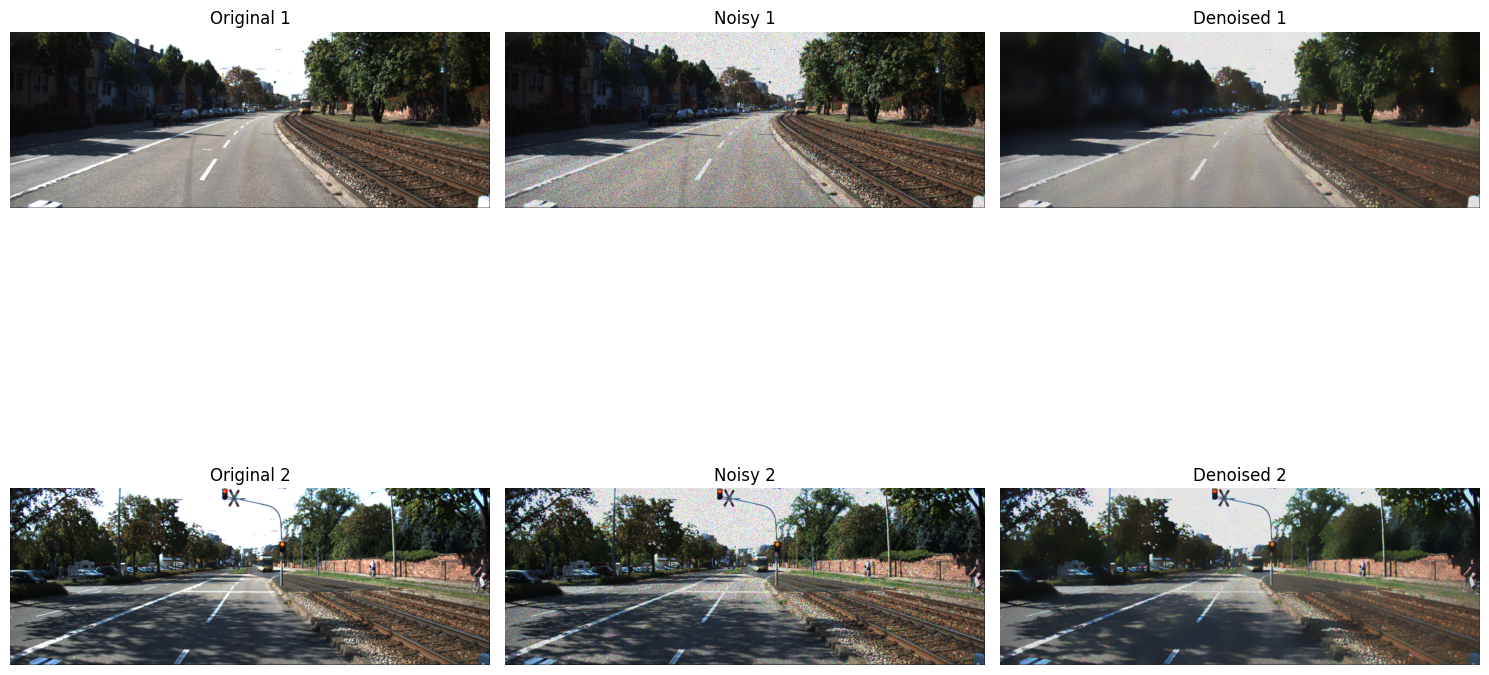

In [ ]:
fig = plt.figure(figsize=(15, 12))
rows = 2
columns = 3

fig.add_subplot(rows, columns, 1)
plt.imshow(imgs[0])
plt.axis('off')
plt.title("Original 1")

fig.add_subplot(rows, columns, 2)
plt.imshow(noisy_imgs[0])
plt.axis('off')
plt.title("Noisy 1")

fig.add_subplot(rows, columns, 3)
plt.imshow(denoised_imgs[0])
plt.axis('off')
plt.title("Denoised 1")

fig.add_subplot(rows, columns, 4)
plt.imshow(imgs[-1])
plt.axis('off')
plt.title("Original 2")

fig.add_subplot(rows, columns, 5)
plt.imshow(noisy_imgs[-1])
plt.axis('off')
plt.title("Noisy 2")

fig.add_subplot(rows, columns, 6)
plt.imshow(denoised_imgs[-1])
plt.axis('off')
plt.title("Denoised 2")

fig.tight_layout()

## Gaussian blur (21.42/0.72)

In [ ]:
noisy_files = natsorted(glob('/content/drive/MyDrive/188/stage1_data/gaussian_blur/*'))
clean_files = natsorted(glob('/content/drive/MyDrive/188/stage1_data/input_imgs/*'))
print(len(noisy_files))
print(len(clean_files))

11
11


In [ ]:
# Wiener deconvolution with different kernel_sizes and regularization hyperparameters

kernel_sizes = [3, 5, 7, 11, 15]
regularization_params = [0, 0.05, 0.1, 0.15, 0.2]
psnr_sum = 0
ssim_sum = 0

imgs = []
noisy_imgs = []
deconvolved_imgs = []

for noisy_file, clean_file in tqdm(zip(noisy_files, clean_files)):
    img = np.array(Image.open(clean_file)) / 255.0
    noisy_img = np.array(Image.open(noisy_file)) / 255.0

    imgs.append(img)
    noisy_imgs.append(noisy_img)

    red_channel = noisy_img[:,:,0]
    green_channel = noisy_img[:,:,1]
    blue_channel = noisy_img[:,:,2]

    pref_kernel_size = -1
    pref_reg = -1
    max_psnr = -1
    max_ssim = -1

    for reg_param in regularization_params:
      for kernel_size in kernel_sizes:
        psf = np.ones((kernel_size, kernel_size)) / (kernel_size * kernel_size)  # point spread function based on kernel_size

        # Wiener deconvolution
        deconvolved_red = wiener(red_channel, psf, reg_param)
        deconvolved_green = wiener(green_channel, psf, reg_param)
        deconvolved_blue = wiener(blue_channel, psf, reg_param)

        deconvolved_img = np.stack((deconvolved_red, deconvolved_green, deconvolved_blue), axis=-1)

        curr_psnr = psnr(img, deconvolved_img)
        curr_ssim = ssim(img, deconvolved_img, multichannel=True)

        if (curr_psnr > max_psnr and curr_ssim > max_ssim):
          max_ssim = curr_ssim
          max_psnr = curr_psnr
          pref_kernel_size = kernel_size
          pref_reg = reg_param

    psf = np.ones((pref_kernel_size, pref_kernel_size)) / (pref_kernel_size * pref_kernel_size)

    deconvolved_red = wiener(red_channel, psf, pref_reg)
    deconvolved_green = wiener(green_channel, psf, pref_reg)
    deconvolved_blue = wiener(blue_channel, psf, pref_reg)

    deconvolved_img = np.stack((deconvolved_red, deconvolved_green, deconvolved_blue), axis=-1)
    deconvolved_imgs.append(deconvolved_img)

    psnr_sum += max_psnr
    ssim_sum += max_ssim

print(psnr_sum/11.0)
print(ssim_sum/11.0)

0it [00:00, ?it/s]

21.423438712747803
0.7164449309568798


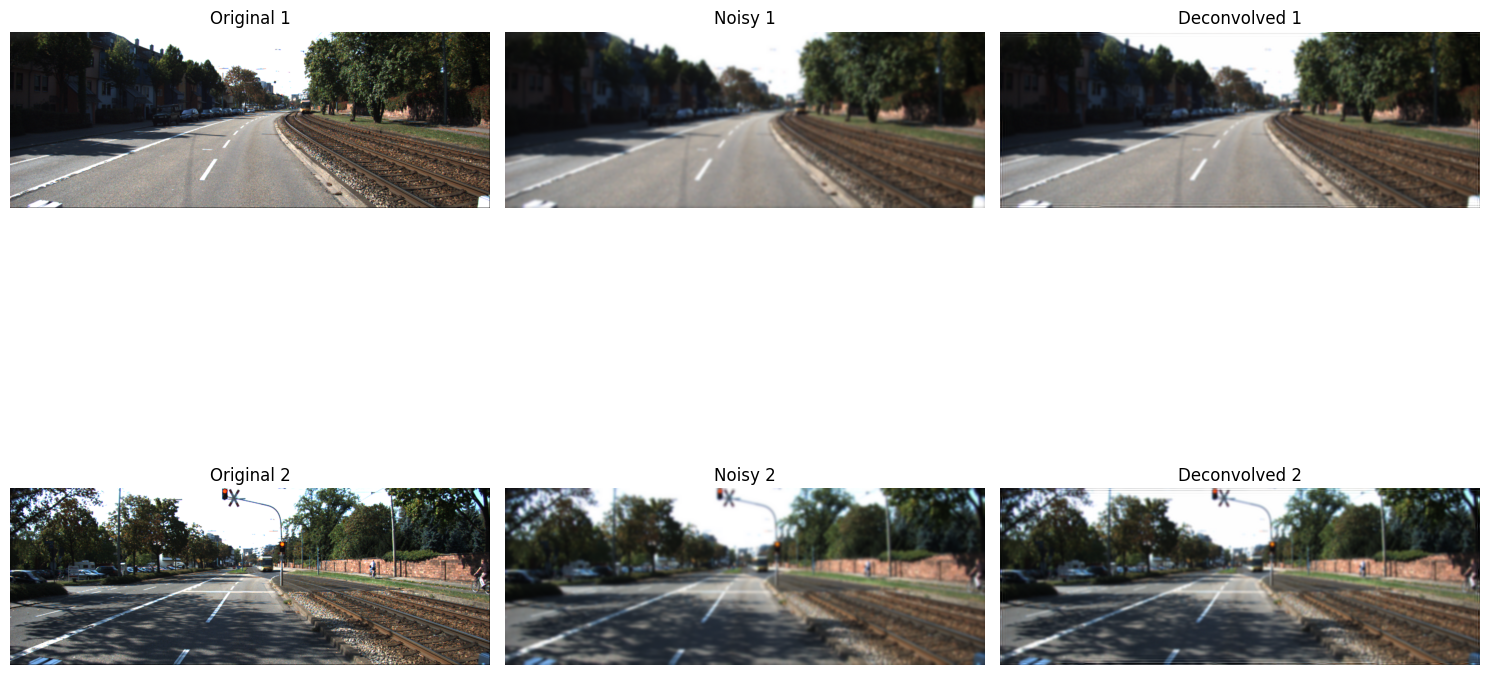

In [ ]:
fig = plt.figure(figsize=(15, 12))
rows = 2
columns = 3

fig.add_subplot(rows, columns, 1)
plt.imshow(imgs[0])
plt.axis('off')
plt.title("Original 1")

fig.add_subplot(rows, columns, 2)
plt.imshow(noisy_imgs[0])
plt.axis('off')
plt.title("Noisy 1")

fig.add_subplot(rows, columns, 3)
plt.imshow(deconvolved_imgs[0])
plt.axis('off')
plt.title("Deconvolved 1")

fig.add_subplot(rows, columns, 4)
plt.imshow(imgs[-1])
plt.axis('off')
plt.title("Original 2")

fig.add_subplot(rows, columns, 5)
plt.imshow(noisy_imgs[-1])
plt.axis('off')
plt.title("Noisy 2")

fig.add_subplot(rows, columns, 6)
plt.imshow(deconvolved_imgs[-1])
plt.axis('off')
plt.title("Deconvolved 2")

fig.tight_layout()

## Motion blur (20.24/0.68)

### Attempt 1: Lucy-Richardson and Wiener tuning (20.24/0.68)

In [78]:
noisy_files = natsorted(glob('/content/drive/MyDrive/188/stage1_data/motion_blur/*'))
clean_files = natsorted(glob('/content/drive/MyDrive/188/stage1_data/input_imgs/*'))
print(len(noisy_files))
print(len(clean_files))

11
11


In [79]:
# Ran Wiener deconvolution using motion blur kernels with varied kernel sizes and all angles (-180 to 180). Based on results, assume kernel_size = 3.
# Tried post-processing techniques such as Sobel filter.
# Ran Lucy-Richardson with the motion blur kernel with different number of iterations. Based on results, num_iters < 10.
# Finally, we tried to just do a brute-force computation with a large hyperparameter set.
# From that, we got that the following parameters:
# lr_iterations = [2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3]
# angles = [118.99, -117.00, 112.96, -149.74, 139.90, -91.92, 139.90, -117.00, -92.09, -54.38, 116.78]
# kernel_sizes = [3, 3, 3, 3, 3, 15, 3, 3, 19, 19, 19]

kernel_sizes = [3, 3, 3, 3, 3, 15, 3, 3, 19, 19, 19]
lr_iterations = [2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3]
angles = [118.99, -117.00, 112.96, -149.74, 139.90, -91.92, 139.90, -117.00, -92.09, -54.38, 116.78]

psnr_sum = 0
ssim_sum = 0

imgs = []
noisy_imgs = []
deconvolved_imgs = []

for noisy_file, clean_file, kernel_size, lr, angle in tqdm(zip(noisy_files, clean_files, kernel_sizes, lr_iterations, angles)):
    img = np.array(Image.open(clean_file)) / 255.0
    noisy_img = np.array(Image.open(noisy_file)) / 255.0

    red_channel = noisy_img[:,:,0]
    green_channel = noisy_img[:,:,1]
    blue_channel = noisy_img[:,:,2]

    motion_blur_kernel = np.zeros((kernel_size, kernel_size))
    motion_blur_kernel[int((kernel_size-1)/2), :] = np.ones(kernel_size) / kernel_size
    rotation_matrix = cv2.getRotationMatrix2D((int((kernel_size-1)/2), int((kernel_size-1)/2)), angle, 1)
    motion_blur_kernel = cv2.warpAffine(motion_blur_kernel, rotation_matrix, (kernel_size, kernel_size))

    deconvolved_red = richardson_lucy(red_channel, motion_blur_kernel, iterations=lr)
    deconvolved_green = richardson_lucy(green_channel, motion_blur_kernel, iterations=lr)
    deconvolved_blue = richardson_lucy(blue_channel, motion_blur_kernel, iterations=lr)

    deconvolved_img = np.stack((deconvolved_red, deconvolved_green, deconvolved_blue), axis=-1)

    psnr_sum += psnr(img, deconvolved_img)
    ssim_sum += ssim(img, deconvolved_img, multichannel=True)

    imgs.append(img)
    noisy_imgs.append(noisy_img)
    deconvolved_imgs.append(deconvolved_img)

print(psnr_sum/11.0)
print(ssim_sum/11.0)

0it [00:00, ?it/s]

20.235576683590367
0.6768531285808593


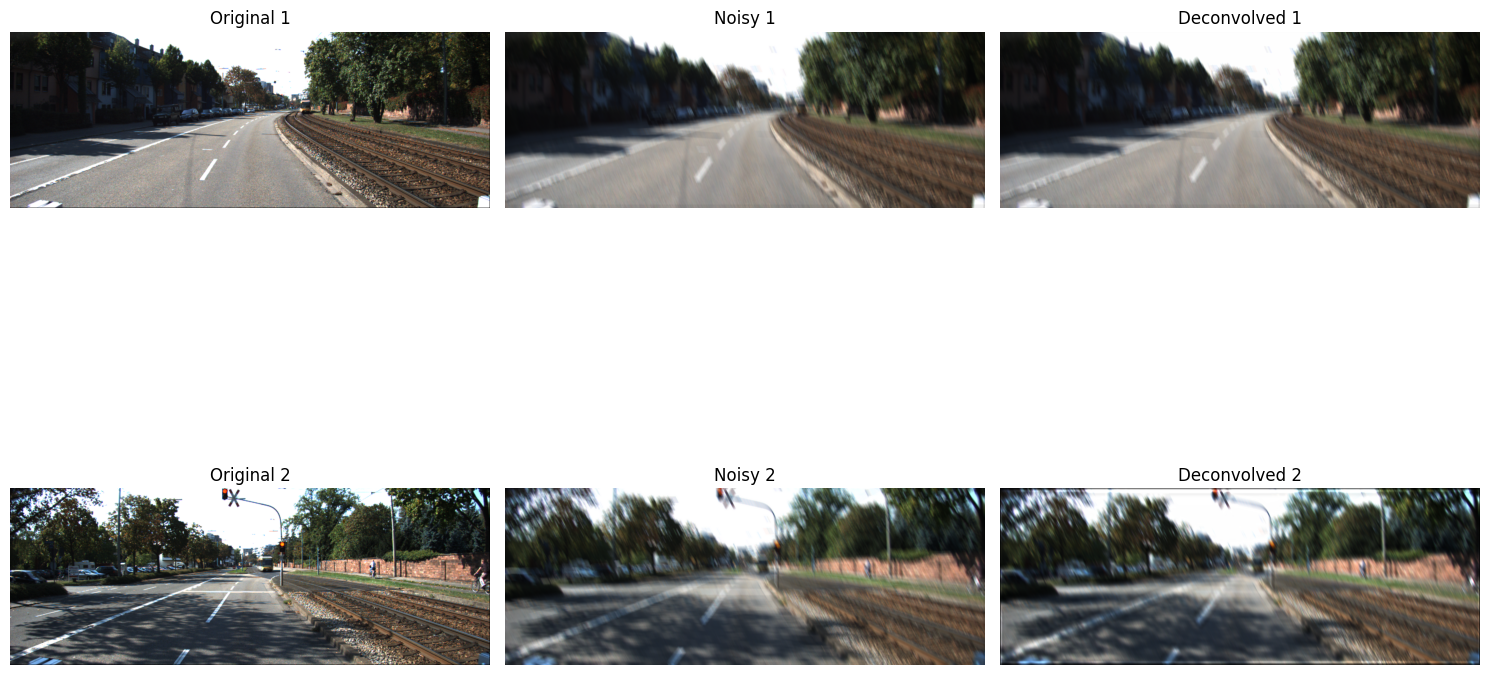

In [80]:
fig = plt.figure(figsize=(15, 12))
rows = 2
columns = 3

fig.add_subplot(rows, columns, 1)
plt.imshow(imgs[0])
plt.axis('off')
plt.title("Original 1")

fig.add_subplot(rows, columns, 2)
plt.imshow(noisy_imgs[0])
plt.axis('off')
plt.title("Noisy 1")

fig.add_subplot(rows, columns, 3)
plt.imshow(deconvolved_imgs[0])
plt.axis('off')
plt.title("Deconvolved 1")

fig.add_subplot(rows, columns, 4)
plt.imshow(imgs[-1])
plt.axis('off')
plt.title("Original 2")

fig.add_subplot(rows, columns, 5)
plt.imshow(noisy_imgs[-1])
plt.axis('off')
plt.title("Noisy 2")

fig.add_subplot(rows, columns, 6)
plt.imshow(deconvolved_imgs[-1])
plt.axis('off')
plt.title("Deconvolved 2")

fig.tight_layout()

### Attempt 2: Estimating blur kernel using FFT (Perfect estimation but not blind)

In [83]:
noisy_files = natsorted(glob('/content/drive/MyDrive/188/stage1_data/motion_blur/*'))
clean_files = natsorted(glob('/content/drive/MyDrive/188/stage1_data/input_imgs/*'))
print(len(noisy_files))
print(len(clean_files))

11
11


In [84]:
# To avoid division by zero
eps = 1e-10

def calculate_kernel_fft(img, noisy_img):
  # FFT of the two images
  fft = fft2(img)
  noisy_fft = fft2(noisy_img)

  # Calculate blur kernel in frequency domain (avoid division by zero)
  kernel_fft = noisy_fft / (fft + eps)

  return noisy_fft, kernel_fft

In [85]:
# Try to estimate blur kernel in frequency domain and restore image
psnr_sum = 0
ssim_sum = 0

imgs = []
noisy_imgs = []
deconvolved_imgs = []

for noisy_file, clean_file in tqdm(zip(noisy_files, clean_files)):
    img = np.array(Image.open(clean_file)) / 255.0
    noisy_img = np.array(Image.open(noisy_file)) / 255.0

    red_channel = noisy_img[:,:,0]
    green_channel = noisy_img[:,:,1]
    blue_channel = noisy_img[:,:,2]

    noisy_red_fft, red_kernel_fft = calculate_kernel_fft(img[:,:,0], red_channel)
    noisy_green_fft, green_kernel_fft = calculate_kernel_fft(img[:,:,1], green_channel)
    noisy_blue_fft, blue_kernel_fft = calculate_kernel_fft(img[:,:,2], blue_channel)

    # Get a restored image by removing blur kernel from the blurred image
    restored_red_fft = noisy_red_fft / (red_kernel_fft + eps)
    restored_green_fft = noisy_green_fft / (green_kernel_fft + eps)
    restored_blue_fft = noisy_blue_fft / (blue_kernel_fft + eps)

    # Convert back to spatial domain and handle possible complex numbers
    deconvolved_red = np.abs(ifft2(restored_red_fft))
    deconvolved_green = np.abs(ifft2(restored_green_fft))
    deconvolved_blue = np.abs(ifft2(restored_blue_fft))
    deconvolved_img = np.stack((deconvolved_red, deconvolved_green, deconvolved_blue), axis=-1)

    psnr_sum += psnr(img, deconvolved_img)
    ssim_sum += ssim(img, deconvolved_img, multichannel=True)

    imgs.append(img)
    noisy_imgs.append(noisy_img)
    deconvolved_imgs.append(deconvolved_img)

print(psnr_sum/11.0)
print(ssim_sum/11.0)

0it [00:00, ?it/s]

188.308503423799
0.9999999999999978


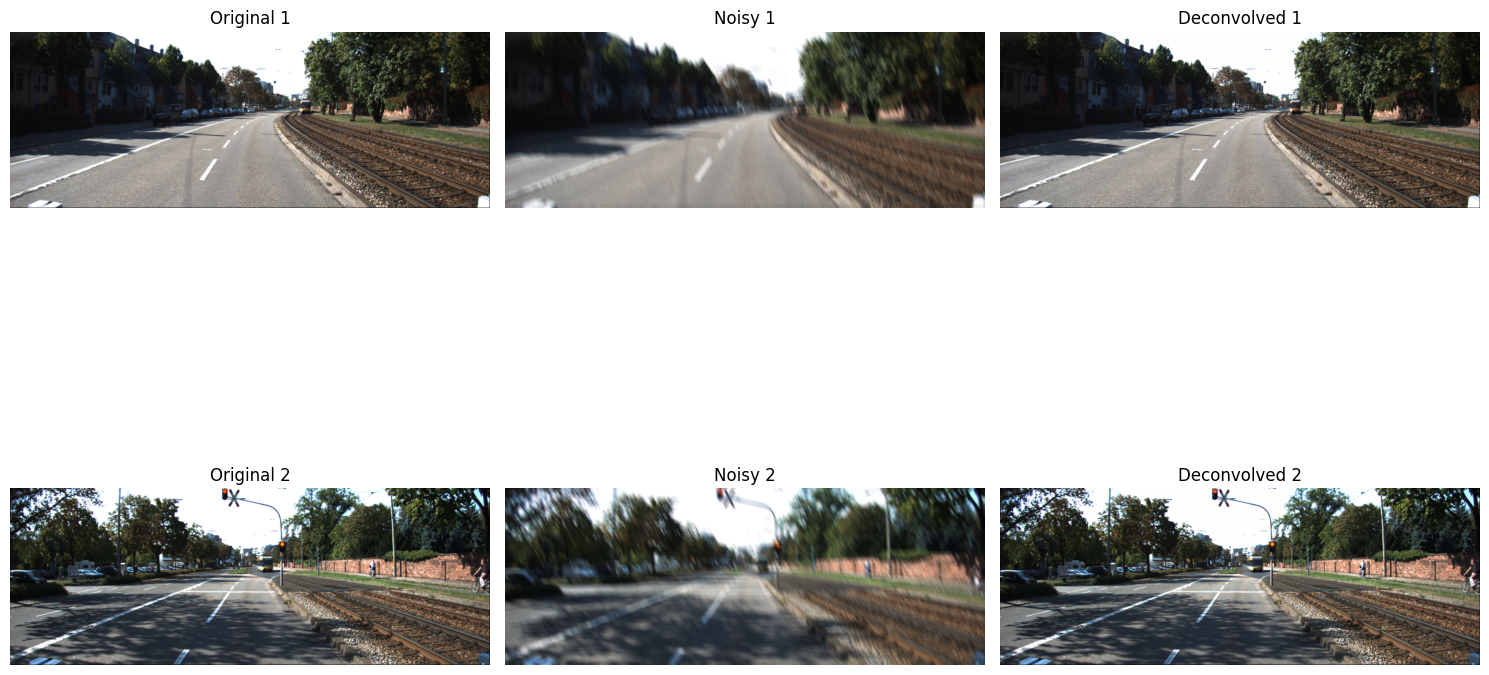

In [86]:
fig = plt.figure(figsize=(15, 12))
rows = 2
columns = 3

fig.add_subplot(rows, columns, 1)
plt.imshow(imgs[0])
plt.axis('off')
plt.title("Original 1")

fig.add_subplot(rows, columns, 2)
plt.imshow(noisy_imgs[0])
plt.axis('off')
plt.title("Noisy 1")

fig.add_subplot(rows, columns, 3)
plt.imshow(deconvolved_imgs[0])
plt.axis('off')
plt.title("Deconvolved 1")

fig.add_subplot(rows, columns, 4)
plt.imshow(imgs[-1])
plt.axis('off')
plt.title("Original 2")

fig.add_subplot(rows, columns, 5)
plt.imshow(noisy_imgs[-1])
plt.axis('off')
plt.title("Noisy 2")

fig.add_subplot(rows, columns, 6)
plt.imshow(deconvolved_imgs[-1])
plt.axis('off')
plt.title("Deconvolved 2")

fig.tight_layout()